In [1]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time
import copy

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

In [2]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


In [3]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [4]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]  # (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective_mlp(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy_mlp(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs_mlp(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective_mlp(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective_mlp(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy_mlp(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy_mlp(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

In [12]:
def make_plot_for_hidden_size(hidden_size, learning_rate=5e-3, reg_param=0.0):
    ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
          1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
    bs = [torch.zeros(hidden_size, requires_grad=True),
          torch.zeros(n_class, requires_grad=True)]

    logs = []

    logs.append(compute_logs_mlp(ws, bs, reg_param, verbose=True))
    verbose = False

    for epoch in range(100):
        num_examples = X_train.shape[0]
        average_loss = 0.0
        for i in range(num_examples):
            idx = np.random.choice(X_train.shape[0])
            # compute the objective. 
            # Note: This function requires X to be of shape (n,d). In this case, n=1 
            objective = compute_objective_mlp(
                ws, bs, X_train[idx:idx+1], y_train[idx:idx+1], reg_param) 
            average_loss = 0.99 * average_loss + 0.01 * objective.item()
            if epoch == 0 and verbose and (i+1) % 100 == 0:
                print(average_loss)

            # compute the gradient using automatic differentiation
            all_parameters = [*ws, *bs]
            gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)

            # perform SGD update. IMPORTANT: Make the update inplace!
            with torch.no_grad():
                for (w, g) in zip(all_parameters, gradients):
                    w -= learning_rate * g
            previous_gradients = gradients
        
        print(epoch, end=', ')
        logs.append(compute_logs_mlp(ws, bs, reg_param, verbose=True))

    logs = np.asarray(logs)

    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(logs[:, 0], label='Train')
    ax[0].plot(logs[:, 2], label='Test')
    ax[0].set_title(f'Loss (width={ws[0].shape[1]})', fontsize=18)
    ax[0].set_xlabel('#Passes', fontsize=18)

    ax[1].plot(logs[:, 1], label='Train')
    ax[1].plot(logs[:, 3], label='Test')
    ax[1].set_title('Accuracy', fontsize=18)
    ax[1].set_xlabel('#Passes', fontsize=18)

    ax[0].legend(fontsize=18)

    ax[0].set_ylim(0, 1.5)
    ax[1].set_ylim(0.75, 1.01)
    
    plt.tight_layout()
    
    return logs




Train Loss = 2.303, Train Accuracy = 0.143, Test Loss = 2.303, Test Accuracy = 0.145
0, Train Loss = 0.644, Train Accuracy = 0.755, Test Loss = 0.705, Test Accuracy = 0.745
1, Train Loss = 0.526, Train Accuracy = 0.816, Test Loss = 0.632, Test Accuracy = 0.784
2, Train Loss = 0.435, Train Accuracy = 0.843, Test Loss = 0.586, Test Accuracy = 0.805
3, Train Loss = 0.423, Train Accuracy = 0.843, Test Loss = 0.627, Test Accuracy = 0.793
4, Train Loss = 0.417, Train Accuracy = 0.855, Test Loss = 0.625, Test Accuracy = 0.807
5, Train Loss = 0.356, Train Accuracy = 0.879, Test Loss = 0.600, Test Accuracy = 0.813
6, Train Loss = 0.357, Train Accuracy = 0.875, Test Loss = 0.604, Test Accuracy = 0.812
7, Train Loss = 0.352, Train Accuracy = 0.880, Test Loss = 0.641, Test Accuracy = 0.807
8, Train Loss = 0.362, Train Accuracy = 0.873, Test Loss = 0.674, Test Accuracy = 0.808
9, Train Loss = 0.317, Train Accuracy = 0.889, Test Loss = 0.653, Test Accuracy = 0.814
10, Train Loss = 0.393, Train Accur

92, Train Loss = 0.092, Train Accuracy = 0.966, Test Loss = 1.754, Test Accuracy = 0.789
93, Train Loss = 0.168, Train Accuracy = 0.946, Test Loss = 1.879, Test Accuracy = 0.784
94, Train Loss = 0.218, Train Accuracy = 0.932, Test Loss = 1.899, Test Accuracy = 0.783
95, Train Loss = 0.117, Train Accuracy = 0.956, Test Loss = 1.744, Test Accuracy = 0.786
96, Train Loss = 0.242, Train Accuracy = 0.924, Test Loss = 2.046, Test Accuracy = 0.770
97, Train Loss = 0.150, Train Accuracy = 0.943, Test Loss = 1.926, Test Accuracy = 0.777
98, Train Loss = 0.204, Train Accuracy = 0.937, Test Loss = 2.108, Test Accuracy = 0.769
99, Train Loss = 0.140, Train Accuracy = 0.952, Test Loss = 1.949, Test Accuracy = 0.777


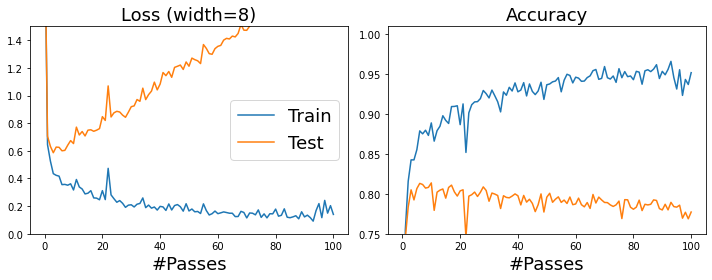

In [14]:
logs_8 = make_plot_for_hidden_size(8)

Train Loss = 2.303, Train Accuracy = 0.071, Test Loss = 2.303, Test Accuracy = 0.072
0, Train Loss = 0.650, Train Accuracy = 0.733, Test Loss = 0.713, Test Accuracy = 0.710
1, Train Loss = 0.458, Train Accuracy = 0.833, Test Loss = 0.594, Test Accuracy = 0.798
2, Train Loss = 0.437, Train Accuracy = 0.844, Test Loss = 0.613, Test Accuracy = 0.791
3, Train Loss = 0.370, Train Accuracy = 0.871, Test Loss = 0.553, Test Accuracy = 0.817
4, Train Loss = 0.317, Train Accuracy = 0.887, Test Loss = 0.535, Test Accuracy = 0.825
5, Train Loss = 0.320, Train Accuracy = 0.886, Test Loss = 0.587, Test Accuracy = 0.817
6, Train Loss = 0.310, Train Accuracy = 0.886, Test Loss = 0.594, Test Accuracy = 0.817
7, Train Loss = 0.276, Train Accuracy = 0.898, Test Loss = 0.624, Test Accuracy = 0.816
8, Train Loss = 0.283, Train Accuracy = 0.901, Test Loss = 0.658, Test Accuracy = 0.821
9, Train Loss = 0.240, Train Accuracy = 0.916, Test Loss = 0.626, Test Accuracy = 0.828
10, Train Loss = 0.234, Train Accur

92, Train Loss = 0.003, Train Accuracy = 0.999, Test Loss = 2.020, Test Accuracy = 0.819
93, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.026, Test Accuracy = 0.818
94, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.039, Test Accuracy = 0.818
95, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.042, Test Accuracy = 0.818
96, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.051, Test Accuracy = 0.818
97, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.051, Test Accuracy = 0.817
98, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.059, Test Accuracy = 0.818
99, Train Loss = 0.002, Train Accuracy = 0.999, Test Loss = 2.062, Test Accuracy = 0.818


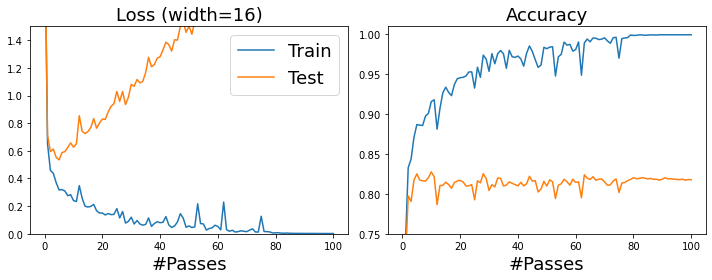

In [15]:
logs_16 = make_plot_for_hidden_size(16)

Train Loss = 2.303, Train Accuracy = 0.104, Test Loss = 2.303, Test Accuracy = 0.110
0, Train Loss = 0.578, Train Accuracy = 0.789, Test Loss = 0.629, Test Accuracy = 0.774
1, Train Loss = 0.448, Train Accuracy = 0.843, Test Loss = 0.568, Test Accuracy = 0.804
2, Train Loss = 0.432, Train Accuracy = 0.850, Test Loss = 0.591, Test Accuracy = 0.809
3, Train Loss = 0.334, Train Accuracy = 0.881, Test Loss = 0.547, Test Accuracy = 0.825
4, Train Loss = 0.317, Train Accuracy = 0.884, Test Loss = 0.551, Test Accuracy = 0.823
5, Train Loss = 0.390, Train Accuracy = 0.852, Test Loss = 0.689, Test Accuracy = 0.775
6, Train Loss = 0.274, Train Accuracy = 0.904, Test Loss = 0.593, Test Accuracy = 0.819
7, Train Loss = 0.296, Train Accuracy = 0.893, Test Loss = 0.649, Test Accuracy = 0.803
8, Train Loss = 0.213, Train Accuracy = 0.922, Test Loss = 0.605, Test Accuracy = 0.830
9, Train Loss = 0.257, Train Accuracy = 0.906, Test Loss = 0.703, Test Accuracy = 0.813
10, Train Loss = 0.251, Train Accur

92, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.518, Test Accuracy = 0.830
93, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.520, Test Accuracy = 0.830
94, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.523, Test Accuracy = 0.829
95, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.526, Test Accuracy = 0.830
96, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.528, Test Accuracy = 0.829
97, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.530, Test Accuracy = 0.829
98, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.531, Test Accuracy = 0.830
99, Train Loss = 0.001, Train Accuracy = 1.000, Test Loss = 1.533, Test Accuracy = 0.830


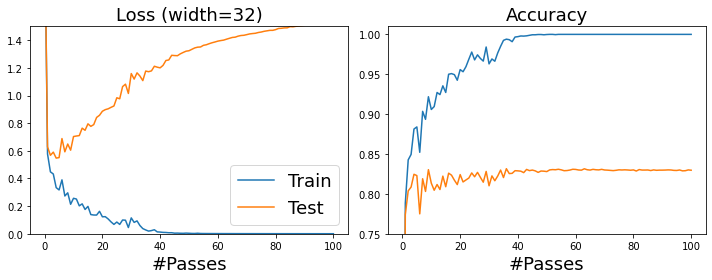

In [16]:
logs_32 = make_plot_for_hidden_size(32)

Train Loss = 2.303, Train Accuracy = 0.056, Test Loss = 2.303, Test Accuracy = 0.056
0, Train Loss = 0.517, Train Accuracy = 0.816, Test Loss = 0.573, Test Accuracy = 0.797
1, Train Loss = 0.446, Train Accuracy = 0.836, Test Loss = 0.555, Test Accuracy = 0.806
2, Train Loss = 0.349, Train Accuracy = 0.878, Test Loss = 0.511, Test Accuracy = 0.821
3, Train Loss = 0.346, Train Accuracy = 0.876, Test Loss = 0.551, Test Accuracy = 0.819
4, Train Loss = 0.340, Train Accuracy = 0.875, Test Loss = 0.612, Test Accuracy = 0.803
5, Train Loss = 0.336, Train Accuracy = 0.872, Test Loss = 0.634, Test Accuracy = 0.797
6, Train Loss = 0.268, Train Accuracy = 0.903, Test Loss = 0.591, Test Accuracy = 0.820
7, Train Loss = 0.216, Train Accuracy = 0.923, Test Loss = 0.569, Test Accuracy = 0.831
8, Train Loss = 0.198, Train Accuracy = 0.927, Test Loss = 0.600, Test Accuracy = 0.827
9, Train Loss = 0.216, Train Accuracy = 0.919, Test Loss = 0.635, Test Accuracy = 0.818
10, Train Loss = 0.197, Train Accur

92, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.208, Test Accuracy = 0.840
93, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.209, Test Accuracy = 0.839
94, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.214, Test Accuracy = 0.840
95, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.213, Test Accuracy = 0.839
96, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.216, Test Accuracy = 0.840
97, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.216, Test Accuracy = 0.839
98, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.220, Test Accuracy = 0.840
99, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.222, Test Accuracy = 0.840


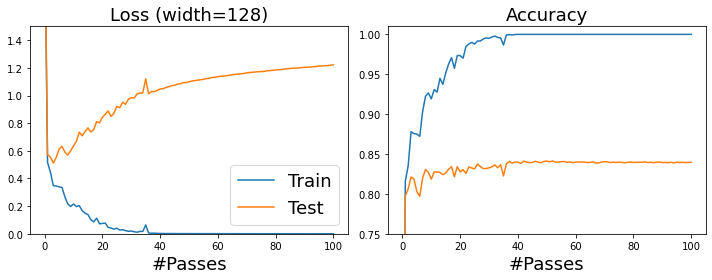

In [17]:
logs_128 = make_plot_for_hidden_size(128)

Train Loss = 2.303, Train Accuracy = 0.132, Test Loss = 2.303, Test Accuracy = 0.138
0, Train Loss = 0.533, Train Accuracy = 0.813, Test Loss = 0.601, Test Accuracy = 0.789
1, Train Loss = 0.455, Train Accuracy = 0.836, Test Loss = 0.592, Test Accuracy = 0.804
2, Train Loss = 0.361, Train Accuracy = 0.870, Test Loss = 0.549, Test Accuracy = 0.821
3, Train Loss = 0.358, Train Accuracy = 0.868, Test Loss = 0.579, Test Accuracy = 0.807
4, Train Loss = 0.283, Train Accuracy = 0.900, Test Loss = 0.561, Test Accuracy = 0.823
5, Train Loss = 0.244, Train Accuracy = 0.910, Test Loss = 0.547, Test Accuracy = 0.834
6, Train Loss = 0.239, Train Accuracy = 0.914, Test Loss = 0.573, Test Accuracy = 0.819
7, Train Loss = 0.233, Train Accuracy = 0.921, Test Loss = 0.620, Test Accuracy = 0.826
8, Train Loss = 0.234, Train Accuracy = 0.915, Test Loss = 0.646, Test Accuracy = 0.818
9, Train Loss = 0.195, Train Accuracy = 0.929, Test Loss = 0.659, Test Accuracy = 0.829
10, Train Loss = 0.163, Train Accur

92, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.131, Test Accuracy = 0.843
93, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.134, Test Accuracy = 0.843
94, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.135, Test Accuracy = 0.843
95, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.138, Test Accuracy = 0.843
96, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.139, Test Accuracy = 0.842
97, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.142, Test Accuracy = 0.843
98, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.143, Test Accuracy = 0.843
99, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.143, Test Accuracy = 0.842


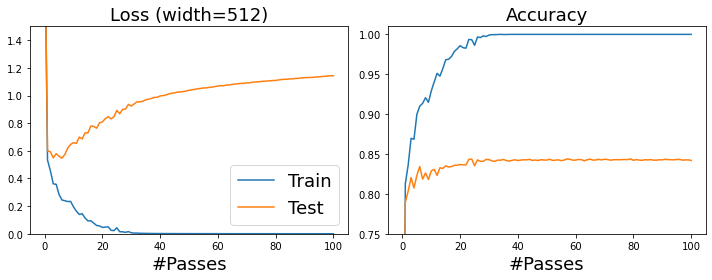

In [18]:
logs_512 = make_plot_for_hidden_size(512)

Train Loss = 2.303, Train Accuracy = 0.093, Test Loss = 2.303, Test Accuracy = 0.087
0, Train Loss = 0.521, Train Accuracy = 0.812, Test Loss = 0.580, Test Accuracy = 0.792
1, Train Loss = 0.456, Train Accuracy = 0.839, Test Loss = 0.562, Test Accuracy = 0.808
2, Train Loss = 0.368, Train Accuracy = 0.864, Test Loss = 0.577, Test Accuracy = 0.804
3, Train Loss = 0.353, Train Accuracy = 0.870, Test Loss = 0.596, Test Accuracy = 0.814
4, Train Loss = 0.332, Train Accuracy = 0.882, Test Loss = 0.638, Test Accuracy = 0.807
5, Train Loss = 0.262, Train Accuracy = 0.906, Test Loss = 0.594, Test Accuracy = 0.828
6, Train Loss = 0.267, Train Accuracy = 0.900, Test Loss = 0.651, Test Accuracy = 0.813
7, Train Loss = 0.232, Train Accuracy = 0.916, Test Loss = 0.627, Test Accuracy = 0.826
8, Train Loss = 0.212, Train Accuracy = 0.927, Test Loss = 0.650, Test Accuracy = 0.827
9, Train Loss = 0.183, Train Accuracy = 0.933, Test Loss = 0.649, Test Accuracy = 0.833
10, Train Loss = 0.326, Train Accur

92, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.121, Test Accuracy = 0.842
93, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.124, Test Accuracy = 0.842
94, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.126, Test Accuracy = 0.843
95, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.128, Test Accuracy = 0.842
96, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.130, Test Accuracy = 0.842
97, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.132, Test Accuracy = 0.842
98, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.134, Test Accuracy = 0.842
99, Train Loss = 0.000, Train Accuracy = 1.000, Test Loss = 1.133, Test Accuracy = 0.842


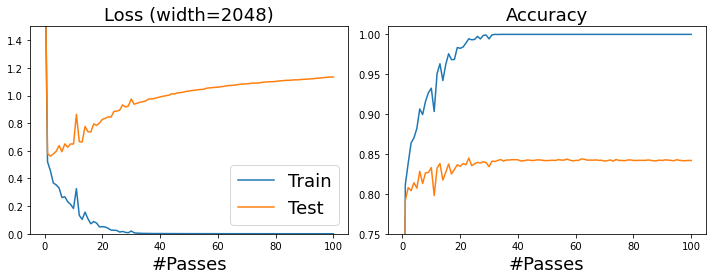

In [20]:
logs_2048 = make_plot_for_hidden_size(2048)